In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches



In [18]:

!curl -LJO  https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/MulticlassDiabetesDataset.csv

diabetes_data = pd.read_csv('MulticlassDiabetesDataset.csv', sep=',')
diabetes_data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11022  100 11022    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Class
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0


In [19]:
#muestras por clase
diabetes = diabetes_data[diabetes_data["Class"] == 2]
print("cantidad diabetes:" ,len(diabetes))
pre_diabetes = diabetes_data[diabetes_data["Class"] == 1]
print("cantidad pre_diabetes:" ,len(pre_diabetes))
normal = diabetes_data[diabetes_data["Class"] == 0]
print("cantidad normal:" , len(normal))


print(len(diabetes_data))

cantidad diabetes: 128
cantidad pre_diabetes: 40
cantidad normal: 96
264


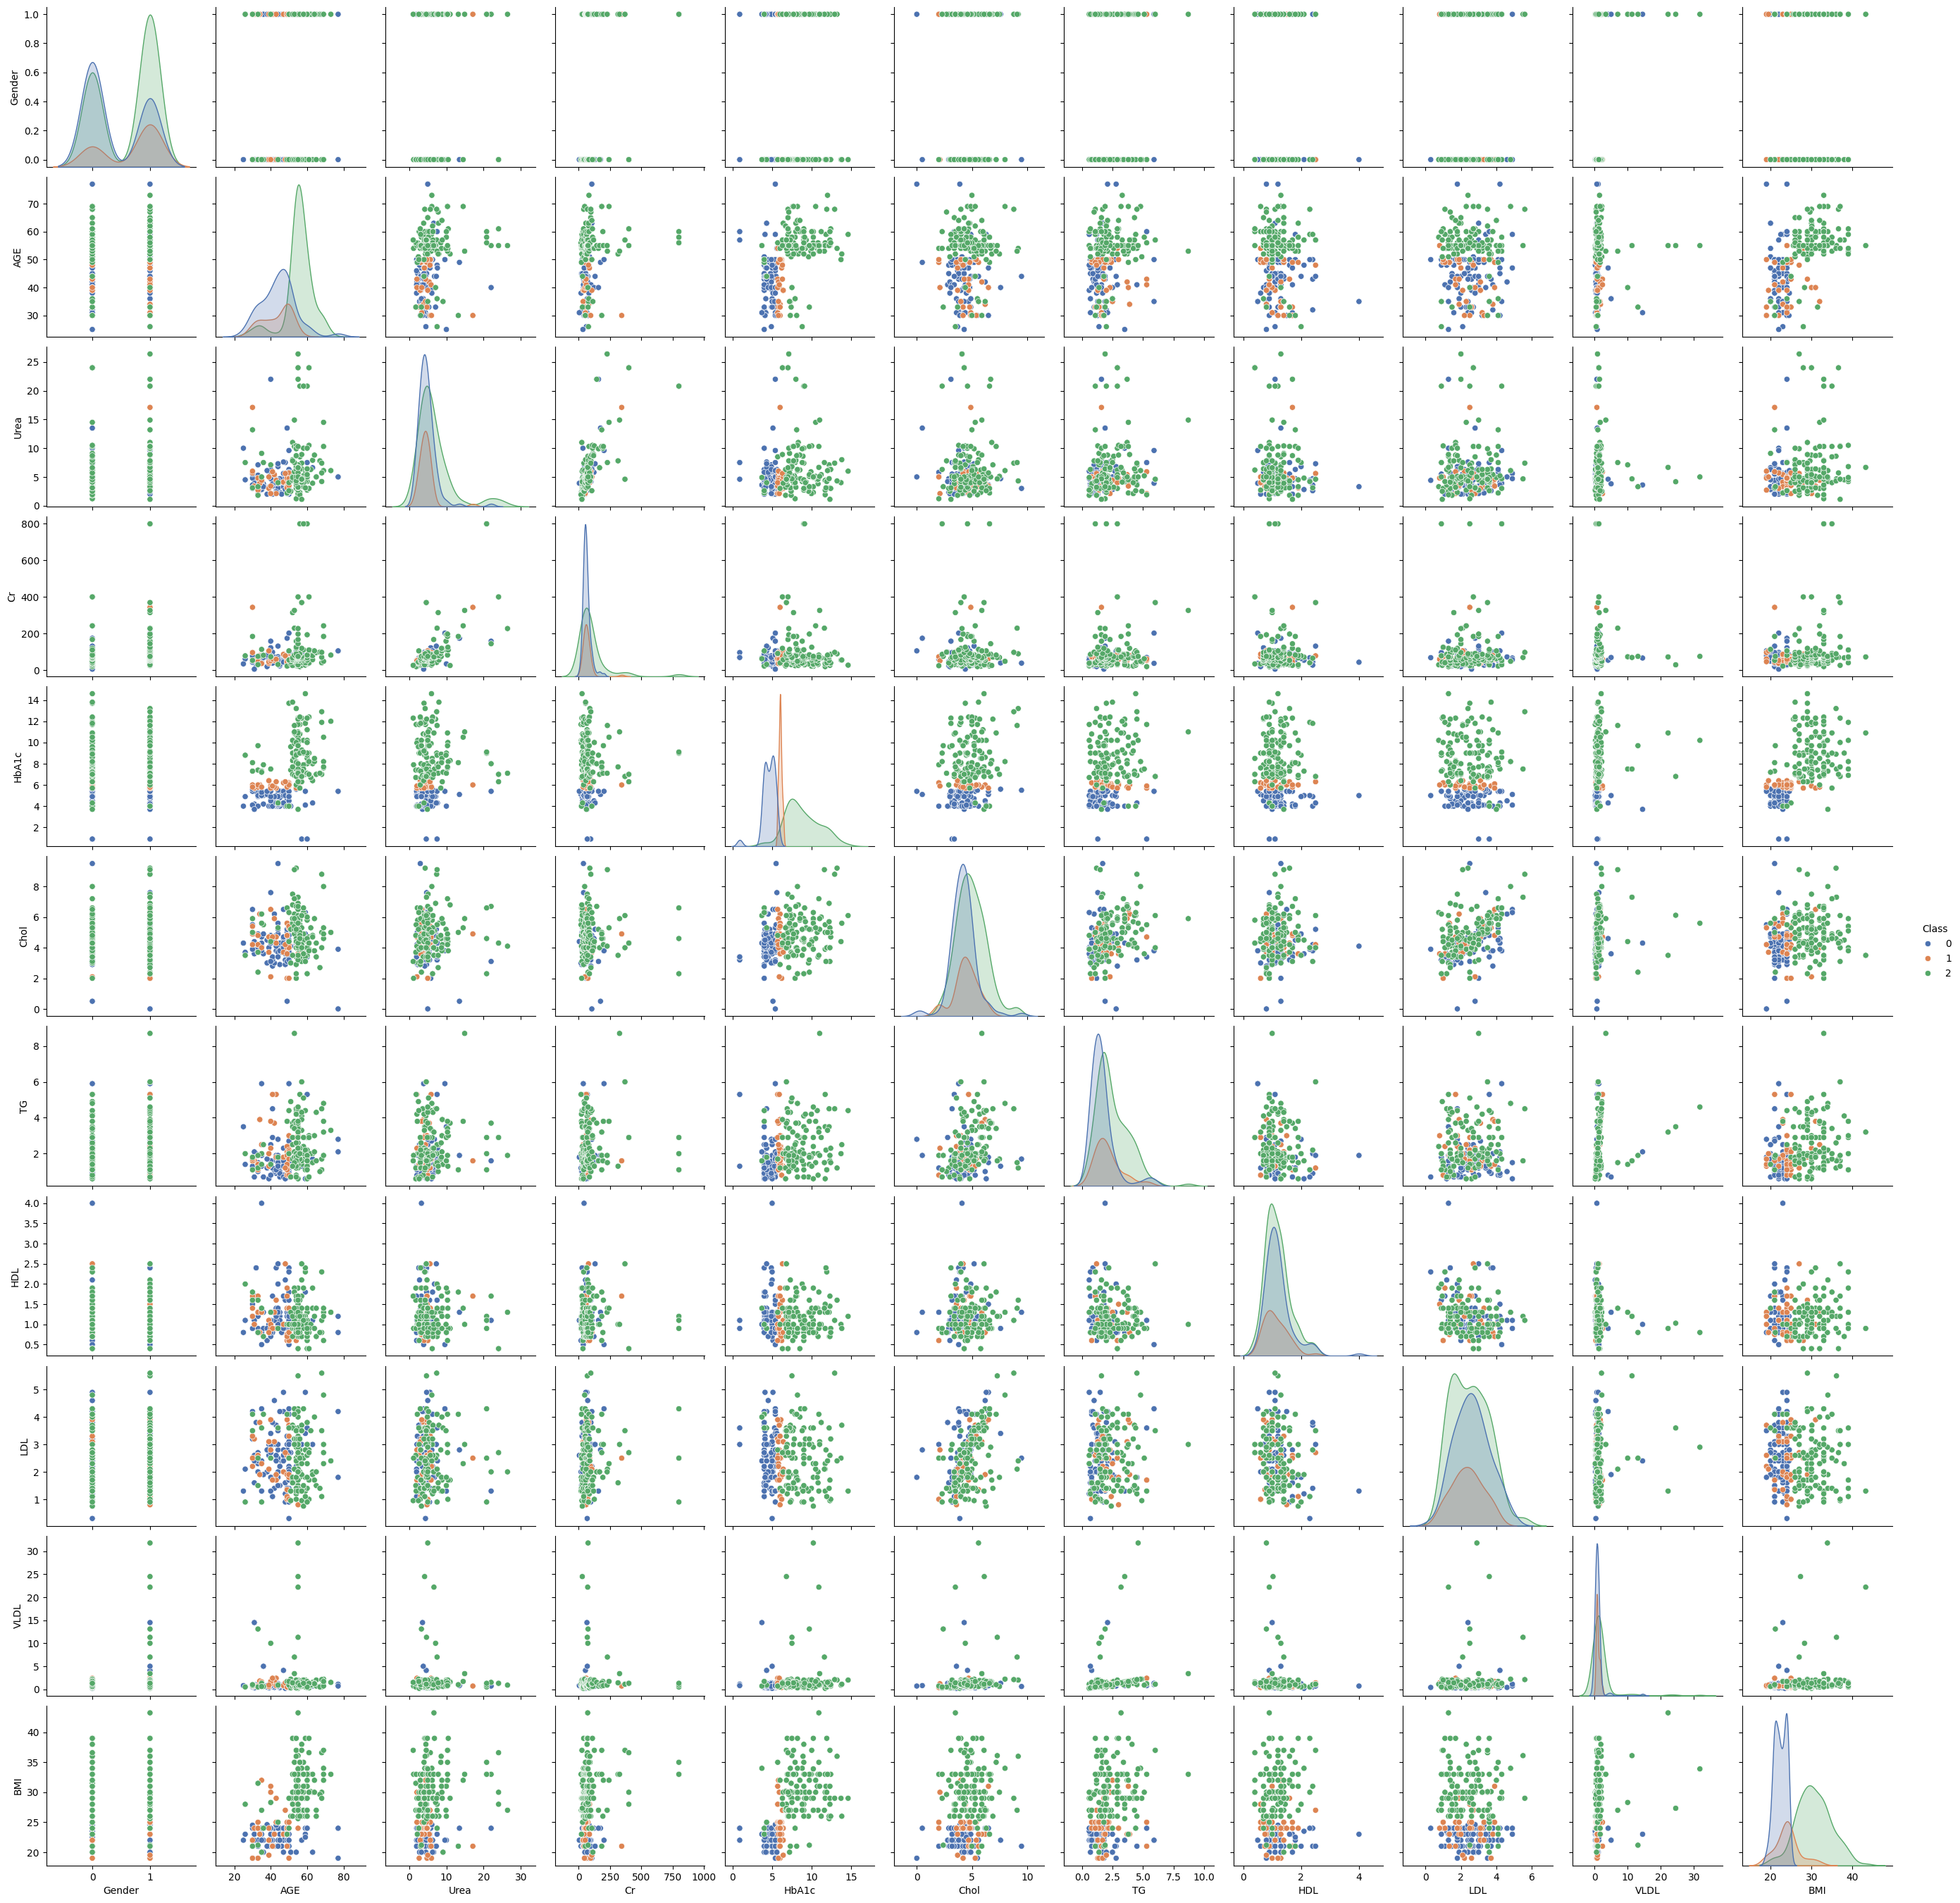

In [20]:
sns.pairplot(diabetes_data, hue="Class", palette="deep")
plt.show()
#verde = diabetes , azul = normal , naranja = pre_diabetes


El pairplot permite visualizar diferentes aspectos del dataset:

En la diagonal principal se muestran las distribuciones individuales de cada variable, diferenciadas por la clase de diagnóstico: normal , prediabetes, diabetes.

Fuera de la diagonal se observan diagramas de dispersión entre pares de variables, lo que facilita analizar posibles relaciones y la separación entre clases.


A su vez podemos observar en la diagonal que algunas variables son mas claras en cuanto a la diferenciacion entre clases que otras, por ejemplo respecto a HbA1c(Nivel de glucosa en los ultimos 3 meses):

Vemos en el grafico de la diagonal que los valores en personas con niveles normales de HbA1c se concentran por debajo de 5.7%. En personas con prediabetes, la distribución presenta un pico entre 5.7% y 6.4%, que corresponde al rango de prevención de esta condición y Los valores en personas con diabetes,se concentran por encima de 6.4%, umbral utilizado para el diagnóstico de la enfermedad.
En los gráficos fuera de la diagonal, se observa que aquellos que incluyen información de HbA1c presentan una separación clara entre las clases. Esto indica que HbA1c es un buen indicador para la detección de la enfermedad.

In [21]:
class LDA_QDA:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, LDA=False):
        self.LDA = LDA
        self.classes_ = None   # Clases
        self.cy = None    # Probabilidades a priori
        self.means_ = None     # Medias por clase
        self.covs_ = None      # Covarianza por clase (QDA) o compartida (LDA)

    # Etapa de entrenamiento
    def fit(self, X, y):
        self.classes_ = np.unique(y) #separo las clases
        K = len(self.classes_)
        n, d = X.shape

        self.is_single_feature = (d == 1)
        self.means_ = np.zeros((K, d))
        self.cy = np.zeros(K)
        if self.LDA:
          self.covs_ = np.zeros((d, d))
        else:
          self.covs_ = []

        for i, k in enumerate(self.classes_):
            Dk = X[y == k] #separo por clase
            self.cy[i] = len(Dk) / n #probabilidad a priori
            self.means_[i] = Dk.mean(axis=0) #media

            cov_k = np.cov(Dk, rowvar=False, bias=False)
            #if self.is_single_feature:
            if d == 1: #caso de 1 solo feature
                cov_k = np.array([[cov_k]])  # varianza como matriz 1x1
            else:
                if cov_k.ndim == 0:
                    cov_k = cov_k.reshape(1,1)
                elif cov_k.ndim == 1:
                    cov_k = np.diag(cov_k)
            if self.LDA:
                self.covs_ += ((len(Dk) - 1) * cov_k)/(n - K)
            else:
                self.covs_.append(cov_k)

    # Etapa de testeo hard
    def predict(self, X):
        scores = self._discriminant(X)
        idx = np.argmax(scores, axis=1) #me quedo con el mas grande y predigo eso
        return self.classes_[idx]

    # Etapa de testeo soft
    def predict_prob(self, X):
        scores = self._discriminant(X)
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) #lo paso a probabilidad
        return exp_scores / exp_scores.sum(axis=1, keepdims=True)

    # Funciones discriminantes
    def _discriminant(self, X):
        n, d = X.shape #muestras, features
        K = len(self.classes_)
        scores = np.zeros((n, K))

        if self.LDA:
            inv_cov = np.linalg.inv(self.covs_) #inversa de la covarianza
            for i in range(K):
                mean = self.means_[i]
                scores[:, i] = X @ inv_cov @ mean - 0.5 * mean.T @ inv_cov @ mean + np.log(self.cy[i])
        else:
            #if self.is_single_feature:
            if d == 1:
                for i in range(K): #para cada clase
                    mean = self.means_[i][0]
                    var = self.covs_[i][0, 0]
                    diff = X[:, 0] - mean
                    scores[:, i] = -0.5 * (diff**2) / var - 0.5 * np.log(var) + np.log(self.cy[i])
            else:
              # QDA multivariado
              X = np.asarray(X)
              for i in range(K):
                mean = self.means_[i]
                cov = self.covs_[i]
                inv_cov = np.linalg.inv(cov)
                det_cov = np.linalg.det(cov)
                for j in range(n):  # para cada muestra
                      x = X[j]
                      diff = x - mean
                      scores[j, i] = -0.5 * (diff.T @ inv_cov @ diff) - 0.5 * np.log(det_cov) + np.log(self.cy[i])
        return scores




In [22]:
#defino una funcion para graficar:
def plot_discriminants(model, x_range, title , variables):
    scores = model._discriminant(x_range)
    y_pred = model.predict(x_range)

    plt.figure(figsize=(8, 5))
    for i, c in enumerate(model.classes_):
        plt.plot(x_range, scores[:, i], label=f"Clase {c}")

    # Dibujar fronteras de decisión
    cambios = np.where(np.diff(y_pred) != 0)[0]
    for idx in cambios:
        plt.axvline(x_range[idx], color="k", linestyle="--")

    plt.title(f"Funciones discriminantes {title}")
    plt.xlabel(variables)
    plt.ylabel("δk(x)")
    plt.legend()
    plt.show()

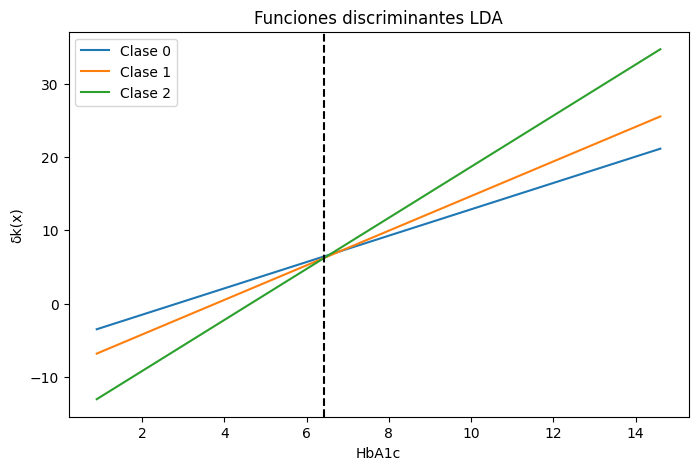

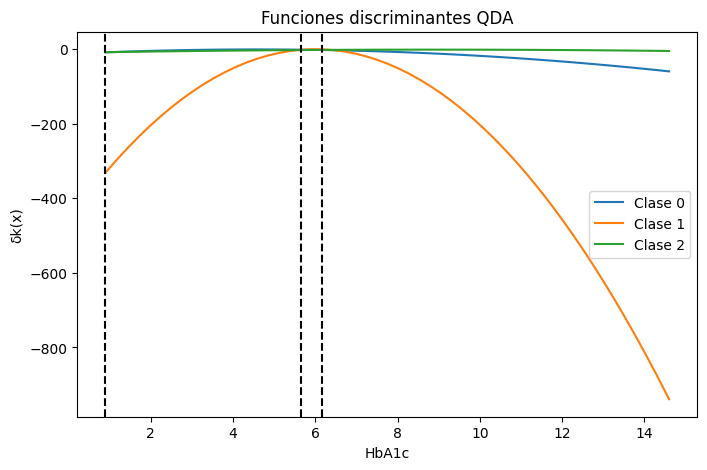

In [23]:
#me quedo solo con la columna de hba1c
#defino los conjuntos de datos
x_data = diabetes_data.drop("Class", axis=1)
y_data = diabetes_data["Class"]
x_train, x_test, y_train, y_test= train_test_split(x_data , y_data , train_size = 0.8, test_size = 0.2)

#Para la primer parte me quedo solo con la columna de la glucosa en sangre para entrenar
x_train_h = x_train["HbA1c"]
x_test_h = x_test["HbA1c"]

LDA = LDA_QDA(LDA=True)
LDA.fit(x_train_h.values.reshape(-1, 1), y_train)
y_pred = LDA.predict(x_test_h.values.reshape(-1, 1))

QDA = LDA_QDA(LDA=False)
QDA.fit(x_train_h.values.reshape(-1, 1), y_train)
y_pred_q = QDA.predict(x_test_h.values.reshape(-1, 1))

# Rango de valores HbA1c para graficar, equiespaciados para graficar
x_range = np.linspace(x_train_h.min(), x_train_h.max(), len(y_test)).reshape(-1, 1)

# --- Graficar LDA y QDA ---
plot_discriminants(LDA, x_range, "LDA", "HbA1c")
plot_discriminants(QDA, x_range, "QDA" , "HbA1c")


Al analizar los resultados, lo esperado sería observar dos fronteras de decisión: una alrededor del 5 % de HbA1c, que separa la categoría Normal de Prediabetes y otra en torno al 6 %, que distingue Prediabetes de Diabetes.

En el gráfico obtenido con LDA, sin embargo, solo se aprecia una única frontera. Esto ocurre porque las tres rectas discriminantes se intersectan prácticamente en un mismo punto, lo que dificulta separar adecuadamente las tres clases.

En cambio, el gráfico generado mediante QDA muestra claramente ambas fronteras de decisión, ubicadas cerca de los valores esperados, lo que permite diferenciar de manera mucho más nítida las tres categorías (Normal, Prediabetes y Diabetes).

In [24]:
#funcion para calcular accuracy, matriz de confusion y macro-F1
def calculo_merito(y_pred, y_test):
   # y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)  # sin labels para que lo infiera solo
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 macro: {f1:.3f}")
    print("Matriz de confusión:\n", cm)


In [25]:
print("Modelo: LDA")
calculo_merito(y_pred , y_test)
print("Modelo: QDA")
calculo_merito(y_pred_q , y_test)

Modelo: LDA
Accuracy: 0.830
F1 macro: 0.590
Matriz de confusión:
 [[19  0  0]
 [ 7  0  0]
 [ 2  0 25]]
Modelo: QDA
Accuracy: 0.962
F1 macro: 0.971
Matriz de confusión:
 [[19  0  0]
 [ 0  7  0]
 [ 2  0 25]]


El accuracy mide la proporción de aciertos totales sobre todas las predicciones. Si una clase es mucho más frecuente que las demás, un clasificador puede obtener un accuracy relativamente alto prediciendo casi siempre esa clase mayoritaria, sin aprender bien las minoritarias.

El macro-F1 es el promedio no ponderado del F1 de cada clase, de modo que cada clase cuenta por igual aunque tenga pocos ejemplos. Esto penaliza fuertemente los errores en clases minoritarias.

$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$


Por eso en nuestros resultados el accuracy y el macro-F1 difieren bastante: aunque el modelo acierta relativamente bien la clase mayoritaria (lo que sube el accuracy), falla mucho en las minoritarias (lo que baja el macro-F1).

En este caso, como solo usamos la variable HbA1c, el clasificador separa bien una clase y no tanto las otras, esto se ve claramente en el caso de LDA , donde no logra clasificar la clase prediabetes

En cuanto a la matriz de confusión podemos notar una relacion con lo graficado, por ejemplo, en el caso LDA, vemos como no puede diferenciar la frontera de las clasificadas como **prediabetes** por lo que en esta matriz podemos observar falla al clasificar las de esta fila

In [26]:
def graficar_2d(H, B, y_predict, x_test, y_test, carac1, carac2, titulo):
    # Colores personalizados (0=normal,1=prediabetes,2=diabetes)
    cmap = mcolors.ListedColormap(["blue", "orange", "green"])
    plt.figure(figsize=(8,6))

    # Fondo coloreado = clase predicha
    plt.contourf(H, B, y_predict, alpha=0.3, cmap=cmap)
    # Líneas de frontera
    plt.contour(H, B, y_predict, colors='k', linewidths=0.5)

    # Puntos del dataset
    plt.scatter(x_test[carac1], x_test[carac2], c=y_test, cmap=cmap, edgecolor='k')

    # Etiquetas de ejes y título
    plt.xlabel(carac1)
    plt.ylabel(carac2)
    plt.title(titulo)

    # Leyenda de colores
    class_names = {0: "Normal", 1: "Prediabetes", 2: "Diabetes"}
    patches = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in class_names]
    plt.legend(handles=patches, title="Clases", loc='upper right')

    plt.show()


Modelo: LDA
Accuracy: 0.811
F1 macro: 0.583
Matriz de confusión:
 [[19  0  0]
 [ 5  0  2]
 [ 2  1 24]]


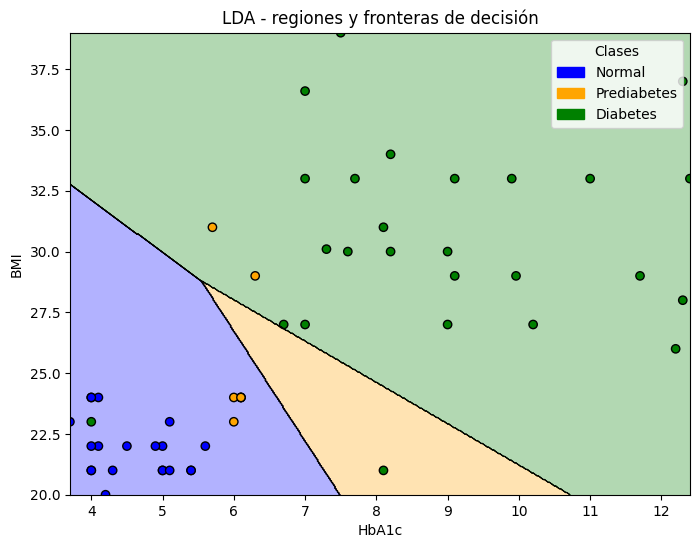

Modelo: QDA
Accuracy: 0.925
F1 macro: 0.903
Matriz de confusión:
 [[19  0  0]
 [ 0  5  2]
 [ 2  0 25]]


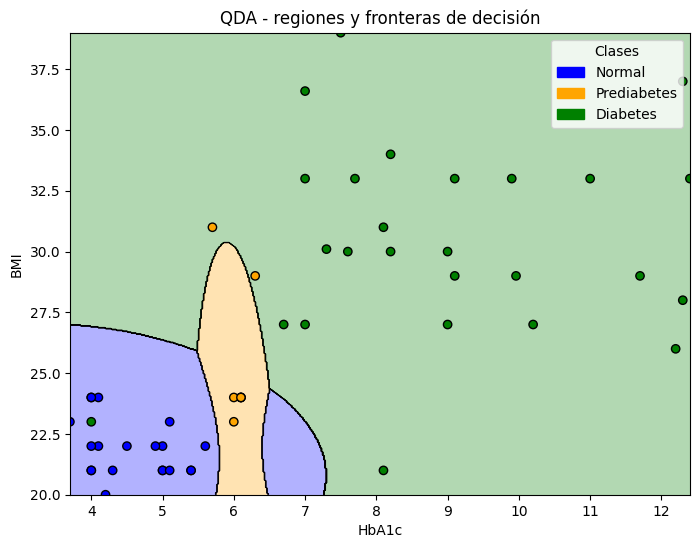

In [27]:
#separo variables
x_train_h_b = x_train[['HbA1c' , 'BMI']]
x_test_h_b  = x_test[['HbA1c' , 'BMI']]
h_vals = np.linspace(x_test_h_b["HbA1c"].min(), x_test_h_b["HbA1c"].max(), 500)
b_vals = np.linspace(x_test_h_b["BMI"].min(),    x_test_h_b["BMI"].max(), 500)
H, B = np.meshgrid(h_vals, b_vals)
grid = np.c_[H.ravel(), B.ravel()]


#---------------------LDA-------------------------------------------------------
#entreno modelos
LDA = LDA_QDA(LDA=True)
LDA.fit(x_train_h_b, y_train)
y_pred_l = LDA.predict(x_test_h_b)

print("Modelo: LDA")
calculo_merito(y_pred_l , y_test)


#grafico
# predicciones sobre la malla (LDA)
y_predict_hb_lda = LDA.predict(grid).reshape(H.shape)

graficar_2d(H , B , y_predict_hb_lda , x_test_h_b , y_test , carac1 = "HbA1c"  , carac2 = "BMI" , titulo="LDA - regiones y fronteras de decisión")
# colores personalizados (0=normal,1=prediabetes,2=diabetes)

#---------------------QDA-------------------------------------------------------

QDA = LDA_QDA(LDA=False)
QDA.fit(x_train_h_b, y_train)
y_pred_q = QDA.predict(x_test_h_b)

print("Modelo: QDA")
calculo_merito(y_pred_q , y_test)

y_predict_hb_qda = QDA.predict(grid).reshape(H.shape)

graficar_2d(H , B , y_predict_hb_qda , x_test_h_b , y_test, carac1 = "HbA1c"  , carac2 = "BMI" , titulo="QDA - regiones y fronteras de decisión")


En este caso se puede observar que al agregar una caracteristica mas mejora la estimacion, aumenta la acurracy en ambos casos y la F1. A su vez graficamente tambien se puede ver una mejora, en el caso de LDA por ejemplo ahora si el modelo define las 3 zonas de clasificación aunque sigue teniendo problemas para clasificar las de la region de prediabetes

In [28]:
#meto todas las caracteristicas

LDA = LDA_QDA(LDA=True)
LDA.fit(x_train, y_train)
y_predict_total_lda = LDA.predict(x_test)
print("Modelo: LDA")
calculo_merito(y_predict_total_lda , y_test)

QDA = LDA_QDA(LDA=False)
QDA.fit(x_train, y_train)
y_predict_total_qda = QDA.predict(x_test)
print("Modelo: QDA")
calculo_merito(y_predict_total_qda , y_test)

#QDA = LDA_QDA(LDA=False)
#QDA.fit(x_train, y_train)
#QDA.predict(x_test)

Modelo: LDA
Accuracy: 0.887
F1 macro: 0.873
Matriz de confusión:
 [[19  0  0]
 [ 1  5  1]
 [ 4  0 23]]
Modelo: QDA
Accuracy: 0.925
F1 macro: 0.940
Matriz de confusión:
 [[17  0  2]
 [ 0  7  0]
 [ 2  0 25]]


Al incorporar todas las características disponibles, tanto accuracy como F1-score presentan valores similares. Esto indica que el modelo ahora logra un equilibrio más uniforme entre precisión y recall para todas las clases. La disminución leve de la accuracy global se debe a que al considerar más características, el modelo puede cometer algunos errores en muestras donde las nuevas variables aportan información ambigua, pero en general mejora la consistencia de la clasificación entre clases, reflejada en la convergencia de F1 y accuracy.

**KNN:**


In [29]:
class KNN:
  # Inicializar atributos y declarar hiperparametros.
  def __init__(self , k):
    self.k = k
    self.classes_ = None

  # Etapa de entrenamiento
  def fit(self , X , y):
    self.X_train = np.array(X)
    if self.X_train.ndim == 1: # si es vector 1D, lo paso a columna
      self.X_train = self.X_train.reshape(-1, 1)
    self.y_train = np.array(y)
    self.classes_ = np.unique(y)

  def predict_proba(self , X):
    x_np = np.array(X)
    if x_np.ndim == 1:
        x_np = x_np.reshape(1, -1)
    y_proba = np.zeros((x_np.shape[0] , len(self.classes_)))
    for i in range(x_np.shape[0]):
      distances = np.linalg.norm(self.X_train - x_np[i] , axis = 1) #calculo las distancias

      indices = np.argsort(distances) #ordeno las distancias
      indices_k = indices[:self.k]# me quedo con los K mas cercanos

      k_mas_cercanos = self.y_train[indices_k] # me fijo el valor de los k mas cercanos
      nombres , counts = np.unique(k_mas_cercanos , return_counts = True) #veo cuantos posibles valores tengo y calculo su probabilidad de ocupacion
      for j in range(len(nombres)):
        y_proba[i , nombres[j]] = counts[j] / self.k #asigno el counts normalizado por el k
    return y_proba

  def predict(self , X):
    y_proba = self.predict_proba(X)
    class_indices = np.argmax(y_proba, axis=1) #me fijo que clase es la que tiene mayor probabilidad, es decir que esta dentro de las k mas cercanas
    return self.classes_[class_indices]#predigo eso

KNN:
Accuracy: 0.962
F1 macro: 0.971
Matriz de confusión:
 [[19  0  0]
 [ 0  7  0]
 [ 2  0 25]]


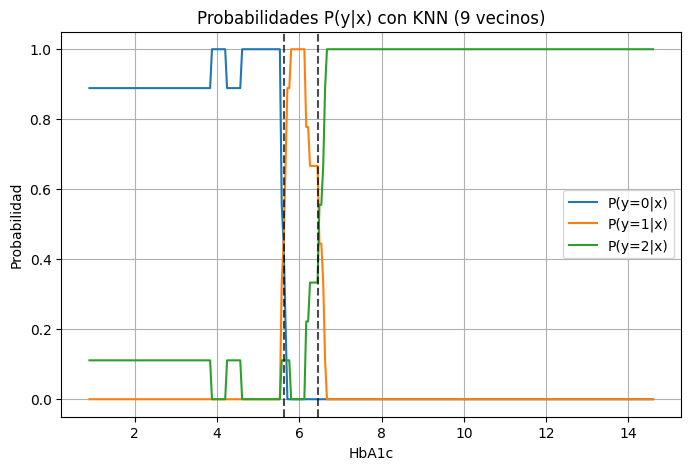

In [30]:
#Armo mi 9NN
knn = KNN(k=9)
knn.fit(x_train_h, y_train)
x_test_h2 = x_test[['HbA1c']]
y_pred_knn = knn.predict(x_test_h2)
#y_pred_knn = knn.predict(x_test_h.values.reshape(-1, 1))

print("KNN:")
calculo_merito(y_pred_knn , y_test)

x_range = np.linspace(x_train_h.min(), x_train_h.max(), 300).reshape(-1, 1)

probas = knn.predict_proba(x_range)

# Graficar P(y|x) para cada clase
plt.figure(figsize=(8,5))
for i, c in enumerate(knn.classes_):
    plt.plot(x_range, probas[:, i], label=f"P(y={c}|x)")

# Frontera de decisión (donde cambia la clase predicha)
y_pred = knn.predict(x_range)
boundaries = np.where(np.diff(y_pred) != 0)[0]
for b in boundaries:
    plt.axvline(x=x_range[b], color="k", linestyle="--", alpha=0.7)

plt.title("Probabilidades P(y|x) con KNN (9 vecinos)")
plt.xlabel("HbA1c")
plt.ylabel("Probabilidad")
plt.legend()
plt.grid(True)
plt.show()



Al observar el gráfico del KNN con k=9, se aprecia que el modelo clasifica las muestras de acuerdo con lo esperado: valores de HbA1c menores a 5 se predicen como Normal, valores entre 5 y 7 como Prediabetes, y valores mayores a 7 como Diabetes.

Además, al analizar las métricas, se observa que accuracy y F1-score presentan valores similares, lo que indica que el modelo no solo predice correctamente la mayoría de las muestras, sino que también mantiene un bajo nivel de errores y un buen equilibrio entre precisión y recall en la clasificación de las distintas clases.

Accuracy: 0.906
F1 macro: 0.875
Matriz de confusión:
 [[19  0  0]
 [ 0  5  2]
 [ 2  1 24]]


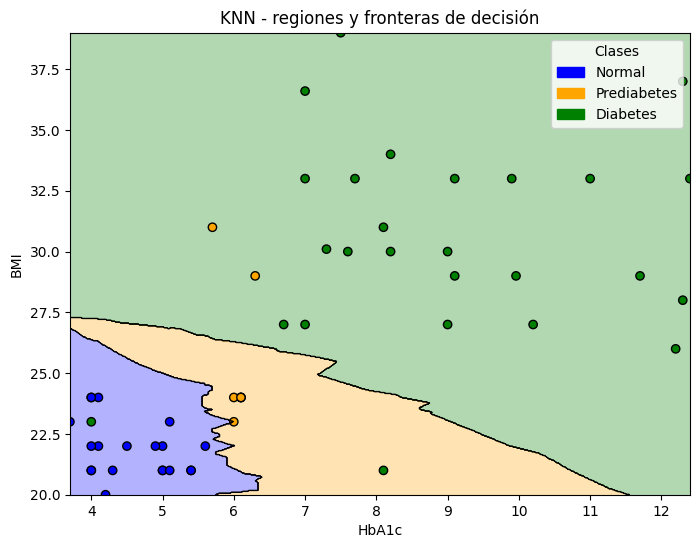

In [31]:
knn.fit(x_train_h_b, y_train)
y_pred_knn_hb = knn.predict(x_test_h_b)
calculo_merito(y_pred_knn_hb , y_test)


y_predict_hb_knn = knn.predict(grid).reshape(H.shape)
# colores personalizados (0=normal,1=prediabetes,2=diabetes)
cmap = mcolors.ListedColormap(["blue", "orange", "green"])
plt.figure(figsize=(8,6))
plt.contourf(H, B, y_predict_hb_knn, alpha=0.3, cmap=cmap)          # fondo coloreado = clase predicha
plt.contour(H, B, y_predict_hb_knn, colors='k', linewidths=0.5)     # líneas de frontera
plt.scatter(x_test_h_b["HbA1c"], x_test_h_b["BMI"], c=y_test, cmap=cmap, edgecolor='k')
plt.xlabel("HbA1c")
plt.ylabel("BMI")
plt.title("KNN - regiones y fronteras de decisión")

# leyenda de colores
class_names = {0: "Normal", 1: "Prediabetes", 2: "Diabetes"}
patches = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in class_names]
plt.legend(handles=patches, title="Clases", loc='upper right')
plt.show()


In [32]:
knn.fit(x_train, y_train)
y_pred_knn_total = knn.predict(x_test)
calculo_merito(y_pred_knn_total , y_test)

Accuracy: 0.868
F1 macro: 0.779
Matriz de confusión:
 [[17  1  1]
 [ 4  3  0]
 [ 1  0 26]]


Para el caso de KNN se puede observar que al tener en cuenta mas caracteristicas empeoran tanto accuracy como F1-score, esto debido a que al tener mas caracteristicas en cuenta el modelo puede llegar a confundir debido a la ambiguedad de los datos. Además, al no existir un proceso explícito de selección o ponderación de variables, KNN trata todas las características como igualmente relevantes, incluso si algunas de ellas no aportan información discriminativa.

